# Getting Started - Vanillix Tutorial

In this tutorial, we'll demonstrate how to use the basic functionalities of our **AUTOENCODIX** pipeline.  
We’ll cover the general **workflow**, show how to work with custom classes, and highlight the pipeline’s flexibility.  
**AUTOENCODIX** supports far more functionality than shown here, so we’ll also point to advanced tutorials where relevant.  

**IMPORTANT**

> This tutorial serves two purposes: (a) introducing the framework in general, and (b) presenting the Vanillix pipeline.  
> For other architectures (e.g., Varix or Ontix), we’ll skip the general concepts and focus only on their specifics.  
> To get a solid overview of the framework, we recommend starting here. We’ll include this note in other tutorials as well, so you can always find the right entry point.

---

## What You'll Learn

You’ll learn how to:

1. **Initialize** the pipeline with a pandas DataFrame. <br><br>
2. Understand the **pipeline steps**. <br><br>
3. Access the pipeline **results** (latent spaces, losses, etc.). <br><br>
4. **Visualize** outputs effectively. <br><br>
5. Apply **custom parameters**. <br><br>
6. **Save, load, and reuse** a trained pipeline. <br><br>

---

Let’s get started! 🚀


## 1) Initialization

To get started, you need three things:  
- A dataset  
- A configuration object  
- The Vanillix pipeline  


#### 📊 Dataset
We allow a variety of inputs (see [1]).  
Here, we demonstrate how to use the pipeline with pandas DataFrames.  

We prepared three mock DataFrames to simulate a multi-omics use case:  
- RNA: `raw_rna`  
- Protein: `raw_protein`  
- Clinical metadata: `annotation`  

For simplicity, we assume paired metadata.  
For handling unpaired data, see [1] or [2]. <br><br>


#### ⚙️ Configuration Object
We use the default parameters in `VanillixConfig`.  

Additionally, we define a `DataCase`, which tells the pipeline what kind of data to expect.  
In this case: `MULTI_BULK`.  

This can be any tabular data and does not have to be bulk sequencing data (we may rename this soon).  
For more details on `DataCase`, refer to [1]. <br><br>


#### 🪈 Vanillix Pipeline
Finally, we import `Vanillix` from our package.  

Each autoencoder architecture comes with a corresponding `pipeline`, which handles the complete analysis process—from preprocessing to evaluation.  
All autoencoders share this unified pipeline interface, which we’ll explore in the next sections. <br><br>


[1] Tutorials/DeepDives/InputDataTutorials.ipynb <br>  
[2] Tutorials/PipelineTutorials/XModalix.ipynb <br>


### 1.1) Inspect Data
Before initializing the pipeline, we’ll show what the input data can look like.  
This should help when working with your own data later.


In [1]:
from autoencodix.utils.example_data import raw_protein, raw_rna, annotation

print(f"Type of raw_rna input: {type(raw_rna)}")

Type of raw_rna input: <class 'pandas.core.frame.DataFrame'>


In [2]:
raw_rna.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_90,gene_91,gene_92,gene_93,gene_94,gene_95,gene_96,gene_97,gene_98,gene_99
sample_0,-0.693594,-0.473079,0.676121,-0.147388,1.201123,-0.414951,0.753255,-1.108531,2.158595,2.086612,...,0.393002,1.086796,-4.323870,2.633942,2.448690,0.091798,2.143187,3.864588,4.332923,-2.012073
sample_1,-7.717414,4.786169,-5.157288,-2.602279,-0.652874,-0.199347,0.883363,-1.917114,2.130440,2.577293,...,-1.764460,1.574903,-6.280627,0.727504,3.392857,1.263027,0.853917,-3.103998,0.276629,-2.708227
sample_2,3.318892,-2.814952,5.125116,-0.222650,1.384565,-5.355473,-2.930422,-1.684189,4.366761,-0.364140,...,0.055857,-0.903358,1.608255,4.002976,0.399693,-0.791146,-2.655789,-0.346798,0.118127,-0.097970
sample_3,0.305501,-2.003316,-5.919967,3.262441,-3.607759,4.005525,3.349946,0.840550,0.173683,-4.018448,...,0.866646,5.055061,-1.797290,-3.199909,3.422235,2.897288,1.775569,0.937340,-2.042406,2.651122
sample_4,-2.942519,1.831377,-1.003791,3.505788,-0.765147,-2.217828,-2.149387,1.377427,-0.134418,1.960087,...,-4.148493,1.730545,-3.276235,0.263396,1.315254,-1.933574,0.764190,-0.877114,-2.640165,-5.108126


In [3]:
annotation.head()

,condition,batch,quality_score
sample_0,condition_0,batch_3,0.883087
sample_1,condition_0,batch_2,0.884084
sample_2,condition_1,batch_2,0.971995
sample_3,condition_1,batch_1,0.718440
sample_4,condition_0,batch_3,0.854322


### 1.2) Initialize Pipeline

In this step, we import the pipeline, configuration, and data classes, and show how to feed pandas DataFrames into the pipeline.  

We use the `DataPackage` class for this purpose. In our case, we fill the attribute `multi_bulk` with a dictionary of pandas DataFrames.  
*Note:* The term *multi* may be misleading — you can also provide just a single DataFrame.  

Metadata is also passed as a dictionary to the `DataPackage`.  
Here, we have one annotation DataFrame for both data modalities (RNA and protein), so we use the identifier `"paired"` as the key.  
Otherwise, you would use the same keys as for the actual data, e.g.:  

```python
{"rna": rna_annotation, "protein": protein_annotation}
```


In [4]:
import autoencodix as acx
from autoencodix.data.datapackage import DataPackage
from autoencodix.configs.vanillix_config import VanillixConfig
from autoencodix.configs.default_config import DataCase

# If your data is stored in pandas DataFrames, you can easily pass them to our custom DataPackage.
# For any tabular data that is not single-cell, provide it as a dictionary to the "multi_bulk" attribute of DataPackage.
# Note: "multi" might be misleading — it's valid to provide just one modality (1–n data modalities).
# Here, we assume paired metadata. If you have separate metadata for each modality, use the same dict keys as in multi_bulk, e.g.:
# annotation = {"rna": rna_annotation, "protein": protein_annotation}
my_datapackage: DataPackage = DataPackage(
    multi_bulk={"rna": raw_rna, "protein": raw_protein},
    annotation={"paired": annotation},
)

myconfig: VanillixConfig = VanillixConfig(data_case=DataCase.MULTI_BULK, epochs=30, device="cpu")
vanillix = acx.Vanillix(data=my_datapackage, config=myconfig)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>


## 2) Pipeline Steps

Next, we explain the four main steps of our pipeline:

1. Preprocess  
2. Fit  
3. Predict  
4. Visualize  

We can run all steps together with the `run` method.


### 2.1) Preprocess

If you're familiar with `AUTOENCODIX 1.0`, this is similar to `make data` in the old framework.  
In case you don’t want any preprocessing, you can set `skip_preprocessing=True` in the config object.  
**ATTENTION:** This could lead to `RuntimeErrors` if you violate assumptions like NaN-free data, which we normally handle during preprocessing.  
See Tutorial [1] for details on data requirements and assumptions.  


#### 🔗 Data Pairing

If you have multiple data modalities, e.g., mRNA and CNA data, and you work with a pipeline that requires paired data (Vanillix, Varix, Ontix, Disentanglix), we drop all samples that are not present in all data modalities.  
If you want to include unpaired data, please refer to [2] and [3].  


#### 🧼 Data Cleaning

This step acts as a safety net to avoid runtime errors later in the pipeline. Here, we simply drop columns with NaN values.  
Ideally, you’ve already cleaned the data before putting it into our pipeline if you want more sophisticated handling of NaNs.  
**Note:** For metadata, we allow NaNs as long as they’re not specified in the config as relevant columns (see [4]).  


#### ✂️ Splitting

We designed the preprocessing pipeline to avoid data leakage, so almost all preprocessing transformations are applied **after** splitting the data.  
The only exception is filtering cells and log-transforming single-cell data (if not already done by you).  
The default behavior is to split your input data into three splits: train, validation, and test. You can define the ratio via the config (see [4]) or, for some pipelines, provide a custom split (see [1]).  
Additionally, you can always pass unseen data to the `predict` step of the pipeline.  


#### 🗂️ Filtering

We filter the columns of the train set and apply the learned filtering to the validation and test sets. The filtering method and the number of features to keep can be defined in the config.  

The filtering method can be set per data modality, but we recommend keeping it consistent.  
If you work with multiple data modalities and provide a number for `k_filter` (e.g., 1000), this will be the total number of features across all data modalities. For example, you may have 500 features for modality A and 500 for modality B.  

We provide the following options for filtering:

- `VAR` – Select features with the highest variance  
- `MAD` – Select features with the highest median absolute deviation  
- `CORR` – Select features based on correlation  
- `VARCORR` – Combination of variance and correlation  
- `NOFILT` – No filtering applied  
- `NONZEROVAR` – Select features with non-zero variance  


#### 📏 Scaling

After the filtering step, we scale the data. We fit the scaler on the train set and apply the learned transformations to the validation and test sets.  

Different scaling methods can be applied per data modality, but we strongly recommend setting this globally via the `scaling` parameter. The default is `StandardScaler`.  

We provide the following options for scaling:  
- `STANDARD` – Standard scaling (mean = 0, variance = 1)  
- `MINMAX` – Min–max scaling to range [0, 1]  
- `ROBUST` – Robust scaling using the median and interquartile range  
- `MAXABS` – Scaling by the maximum absolute value  
- `NONE` – No scaling applied  


#### 🐍 Transforming to PyTorch Dataset

In the last step, we transform the data into a custom PyTorch `Dataset` class.  
For the Vanillix pipeline, we concatenate the different data modalities and store them in the `data` attribute of the `Dataset` class.  
Now the data is ready to serve as input for our PyTorch models.  


[1] Tutorials/DeepDives/InputDataTutorials.ipynb <br>
[2] Tutorials/PipelineTutorials/XModalix.ipynb <br>
[3] Tutorials/PipelineTutorials/Stackix.ipynb <br>
[4] Tutorials/DeepDives/ConfigTutorial.ipynb <br>


#### 🖥️ In Code

All the above steps run with one command in our pipeline:

In [5]:
# This does not return anything; the step updates internal attributes:
# It sets the private _datasets attribute.
# It populates the results.datasets attribute with the preprocessed and transformed PyTorch datasets (one for each split).
vanillix.preprocess()

anno key: paired


### 2.2) The Fit Step

The fit step trains the autoencoder architecture and captures an extensive set of training dynamics.  
The training and model itself are highly customizable (`n_layers`, `latent_dim`, `epochs`, `learning_rate`, etc.). Refer to [Section 5](#5-customize) or Tutorial [4] for more details.  
During training, we capture losses, latent spaces, and reconstructions for each checkpoint epoch and store them in our results object.

[4] Tutorials/DeepDives/ConfigTutorial.ipynb <br>


In [6]:
# Job of the old make_model step.
# Calls self.Trainer class to initialize and train the model.
# Populates the self._model attribute with the trained model.
# Populates the self.results attribute with training results (model, losses, etc.).
vanillix.fit()

Epoch 1 - Train Loss: 31.0526
Sub-losses: recon_loss: 31.0526
Epoch 1 - Valid Loss: 19.0944
Sub-losses: recon_loss: 19.0944
Epoch 2 - Train Loss: 28.3116
Sub-losses: recon_loss: 28.3116
Epoch 2 - Valid Loss: 19.2992
Sub-losses: recon_loss: 19.2992
Epoch 3 - Train Loss: 25.5382
Sub-losses: recon_loss: 25.5382
Epoch 3 - Valid Loss: 19.3715
Sub-losses: recon_loss: 19.3715
Epoch 4 - Train Loss: 24.6340
Sub-losses: recon_loss: 24.6340
Epoch 4 - Valid Loss: 18.8999
Sub-losses: recon_loss: 18.8999
Epoch 5 - Train Loss: 23.6771
Sub-losses: recon_loss: 23.6771
Epoch 5 - Valid Loss: 18.9248
Sub-losses: recon_loss: 18.9248
Epoch 6 - Train Loss: 23.0122
Sub-losses: recon_loss: 23.0122
Epoch 6 - Valid Loss: 18.5808
Sub-losses: recon_loss: 18.5808
Epoch 7 - Train Loss: 22.5824
Sub-losses: recon_loss: 22.5824
Epoch 7 - Valid Loss: 18.4195
Sub-losses: recon_loss: 18.4195
Epoch 8 - Train Loss: 21.5551
Sub-losses: recon_loss: 21.5551
Epoch 8 - Valid Loss: 18.1617
Sub-losses: recon_loss: 18.1617
Epoch 9 

### 2.3) The Predict Step

In this step, we use the trained model to run a forward pass on our test dataset.  
This step can also take a `data` argument, allowing you to run predictions on held-out data other than the test split.  
If you provide new data, preprocessing will be applied automatically depending on the data format — see [1] for details.

[1] Tutorials/DeepDives/InputDataTutorials.ipynb


In [7]:
# Job of the old make_predict step.
# If no data is passed, uses the test split from preprocessing.
# Otherwise, uses the provided data and preprocesses it.
# Updates the self.results attribute with predictions (latent space, reconstructions, etc.).
# Returns a results object.
result = vanillix.predict()

### 2.4) The Visualize Step

This step takes the training results and creates visualizations,  
for example, plots of the loss curve or the latent spaces.  
The plots are stored internally and can be displayed with the `show_result` method.  
See [Section Visualize](#4-visualize) for more details on working with the generated plots.


In [8]:
# Job of old make visualize
vanillix.visualize()

### 2.5) The Run Step

This step combines all the previous steps and returns a results object.  
Furthermore, you can pass a `data` argument, which will then be used in the predict step instead of the test split.


In [9]:
# Calls all the steps in one wrapper:
# vanillix.preprocess()
# vanillix.fit()
# vanillix.predict()
# vanillix.visualize
vanillix = acx.Vanillix(config=myconfig, data=my_datapackage)
result = vanillix.run()
# Also possilbe to pass data: vanillix.run(data=<your-data>)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
anno key: paired
Epoch 1 - Train Loss: 27.0245
Sub-losses: recon_loss: 27.0245
Epoch 1 - Valid Loss: 18.9185
Sub-losses: recon_loss: 18.9185
Epoch 2 - Train Loss: 25.9993
Sub-losses: recon_loss: 25.9993
Epoch 2 - Valid Loss: 19.1620
Sub-losses: recon_loss: 19.1620
Epoch 3 - Train Loss: 23.8369
Sub-losses: recon_loss: 23.8369
Epoch 3 - Valid Loss: 19.0649
Sub-losses: recon_loss: 19.0649
Epoch 4 - Train Loss: 23.1787
Sub-losses: recon_loss: 23.1787
Epoch 4 - Valid Loss: 18.6534
Sub-losses: recon_loss: 18.6534
Epoch 5 - Train Loss: 22.8685
Sub-losses: recon_loss: 22.8685
Epoch 5 - Valid Loss: 18.2932
Sub-losses: recon_loss: 18.2932
Epoch 6 - Train Loss: 21.9572
Sub-losses: recon_loss: 21.9572
Epoch 6 - Valid Loss: 18.0725
Sub-losses: recon_loss: 18.0725
Epoch 7 - Train Loss: 21.4759
Sub-losses: recon_loss: 21.4759
Epoch 7 - Valid Loss: 17.8417
Sub-losses: recon_loss: 17.8417
Epoch 8 - Train Loss: 20.7

### 2.6) Extra: The Evaluate Step

This step is not included when you call `.run()`. Here, we use the `latent space` and compare it to other dimensionality reduction techniques like PCA, UMAP, or a random baseline.  
In the basic case, you can specify a column in your annotation data to use for a machine learning task, e.g., training a classifier on disease state or cancer type. We then use the representations (latent space, UMAP, etc.) to train this classifier/regressor.  
You have many options to customize this step for your needs, such as passing a scikit-learn model and defining evaluation metrics. Please refer to [5] for a complete guide.

[5] Tutorials/DeepDives/EvaluateTutorial.ipynb


Perform ML task with feature df: Latent
Latent
Perform ML task for target parameter: condition
Showing plot for ML algorithm: LogisticRegression()


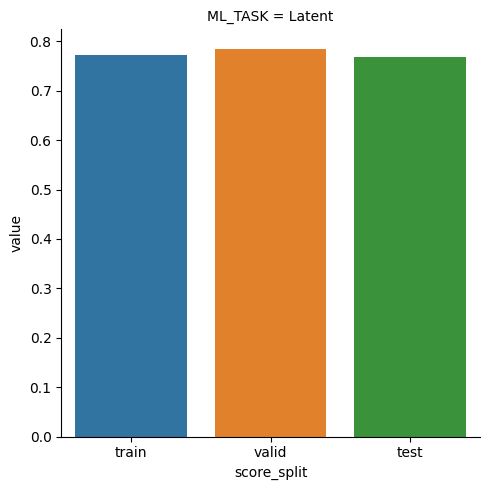

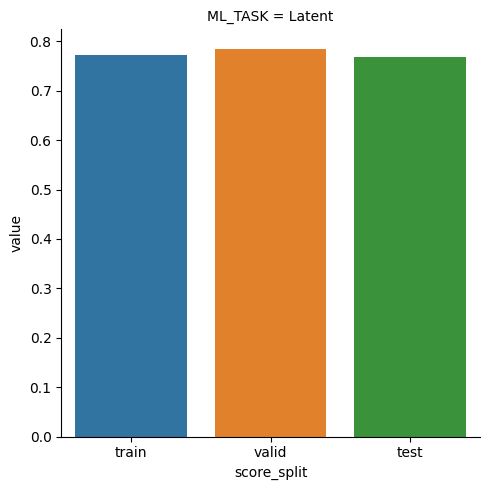

In [10]:
# In our mock DataFrame, we have a column called "condition"
# that refers to some clinical condition.
vanillix.evaluate(params=["condition"])  # TODO: Should also be possible via config using annotation_columns

# Next, we can visualize the evaluation output with:
# TODO: Build a method to avoid exposing the private _visualizer
vanillix.visualizer.show_evaluation(
    param="condition",
    metric="roc_auc_ovo"
)


## 3) Inspect Results

Each step in the pipeline writes its results to the results object of the Vanillix instance.  
In this section, we explore how to access and make sense of the results.  
The attributes of the results object are instances of a `TrainingDynamics` class.  
This class provides a standardized interface for accessing results from different splits and epochs.

##### TrainingDynamics Object in Results

The `TrainingDynamics` object has the following form:  
`<epoch><split><data>`  

For example, to access the train loss for the 5th epoch, you would use:  
```python
result.loss.get(epoch=5, split="train")
```

##### Special Handling

* If an invalid split is provided, a `KeyError` is raised
* Negative epoch indices work like Python list indexing (-1 is the last epoch)
* If an epoch doesn't exist, an empty array or dictionary is returned

---
For more details on how to work with TrainingDynamics and the Result object, refer to [5]
[5]Tutorials/DeepDives/PipelineOutputTutorial.ipynb 



In [11]:
# Get the latent spaces of the test split
rec_test = result.reconstructions.get(split="test")

# Get sample_ids for this latent space
sample_ids = result.sample_ids.get(split="test")

# A utility wrapper to get the latent space as a DataFrame
result.get_latent_df(epoch=-1, split="test")

,LatDim_0,LatDim_1,LatDim_2,LatDim_3,LatDim_4,LatDim_5,LatDim_6,LatDim_7,LatDim_8,LatDim_9,LatDim_10,LatDim_11,LatDim_12,LatDim_13,LatDim_14,LatDim_15
sample_0,-0.382625,0.589906,-0.879909,1.283170,0.671988,-1.302602,1.025041,-1.270478,-0.268375,0.338656,-0.732084,-0.158798,-0.151255,-0.504032,0.822053,0.266233
sample_1,0.111123,0.293038,-0.447430,0.584958,0.448018,-0.585436,0.511536,-0.259539,-0.160843,0.094509,-0.501090,0.157134,-0.095097,-0.213637,0.418756,0.225122
sample_112,1.290208,0.288007,0.054710,1.116661,0.735133,-0.614100,1.009623,-1.144531,0.062279,0.357614,-1.163871,0.307294,0.355081,-0.434494,0.722746,0.837147
sample_115,0.711727,-0.252293,0.145308,0.056205,-0.452803,-0.078507,-0.414320,-0.301762,-0.329187,0.153807,0.533494,0.177138,0.193224,-0.104942,0.140751,0.450501
sample_118,0.778167,0.138936,0.200017,0.622107,-0.907302,0.324699,-0.514724,-0.137610,-0.952645,-0.029310,0.607553,-0.039115,0.234284,0.097316,0.036806,1.261764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_86,1.254664,-0.506045,0.118012,0.103417,-0.587516,0.129932,-0.975044,-0.743501,-0.320690,0.263248,0.601478,0.476836,-0.038587,-0.273930,0.245076,0.676984
sample_91,0.413773,0.320297,0.299408,0.750335,0.104210,0.195634,0.269065,0.189970,-0.583460,-0.702087,-0.220890,-0.101774,0.124846,0.144479,0.065272,0.351230
sample_93,-0.191232,0.527602,-0.029576,1.362643,1.000944,-1.088041,0.716919,0.146464,-0.574146,-0.604133,-1.104499,-0.019053,-0.519702,0.070667,0.430204,0.137972
sample_96,0.372487,-0.082060,0.109445,0.280929,-0.563473,-0.127177,-0.354357,-0.267686,-0.338694,0.189411,0.612864,-0.328346,-0.006980,-0.024948,0.215460,0.579723


## 4) Visualize Results

During the pipeline, the visualize step already prepared some plots.  
You can call the `show_result` method to display the actual plots. By passing the keyword argument `params` and providing a list of columns from the annotation data, you get visualizations based on these columns. In your example we use the `batch` column. This shows us if latent dimension are distributed differently per batch.  
Refer to [5] for more details on how to work with plots.

[5] Tutorials/DeepDives/VisualizeTutorial.ipynb


Creating plots ...


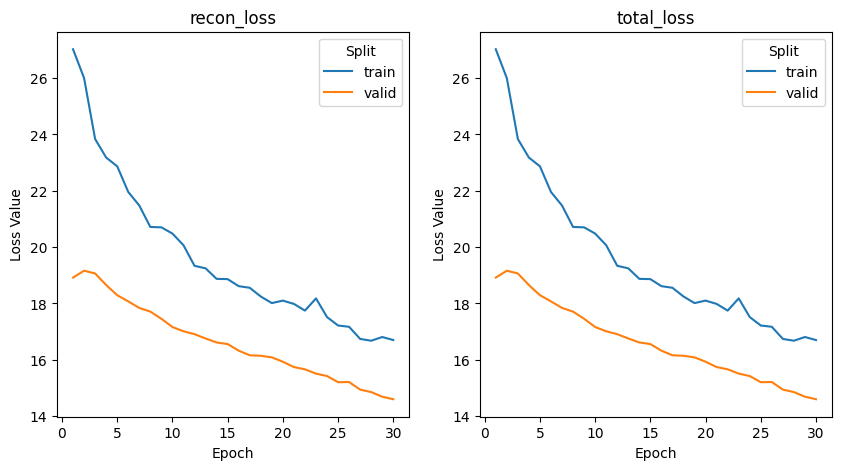

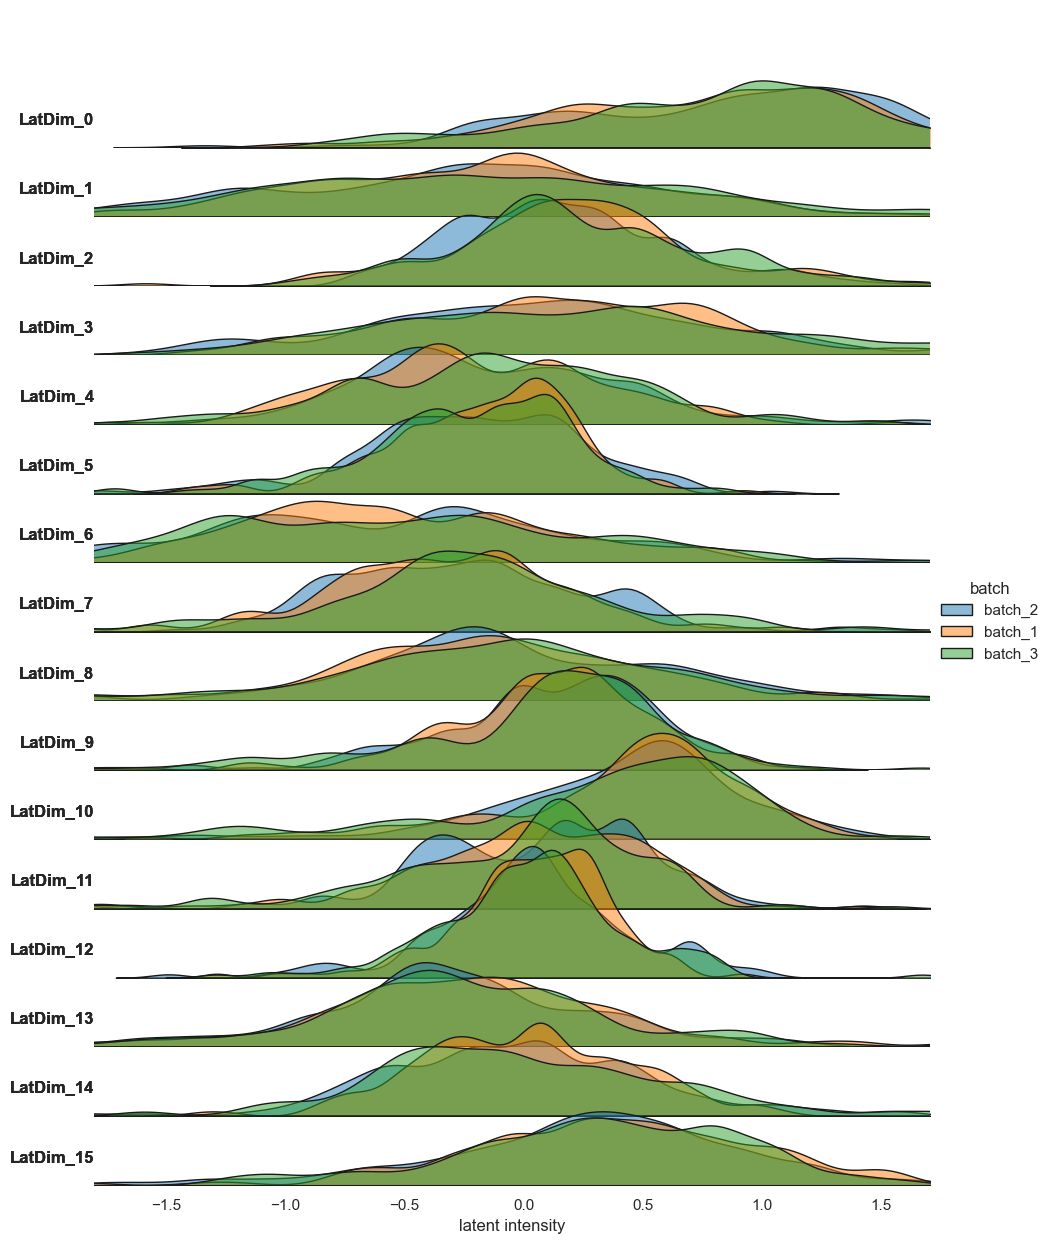

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


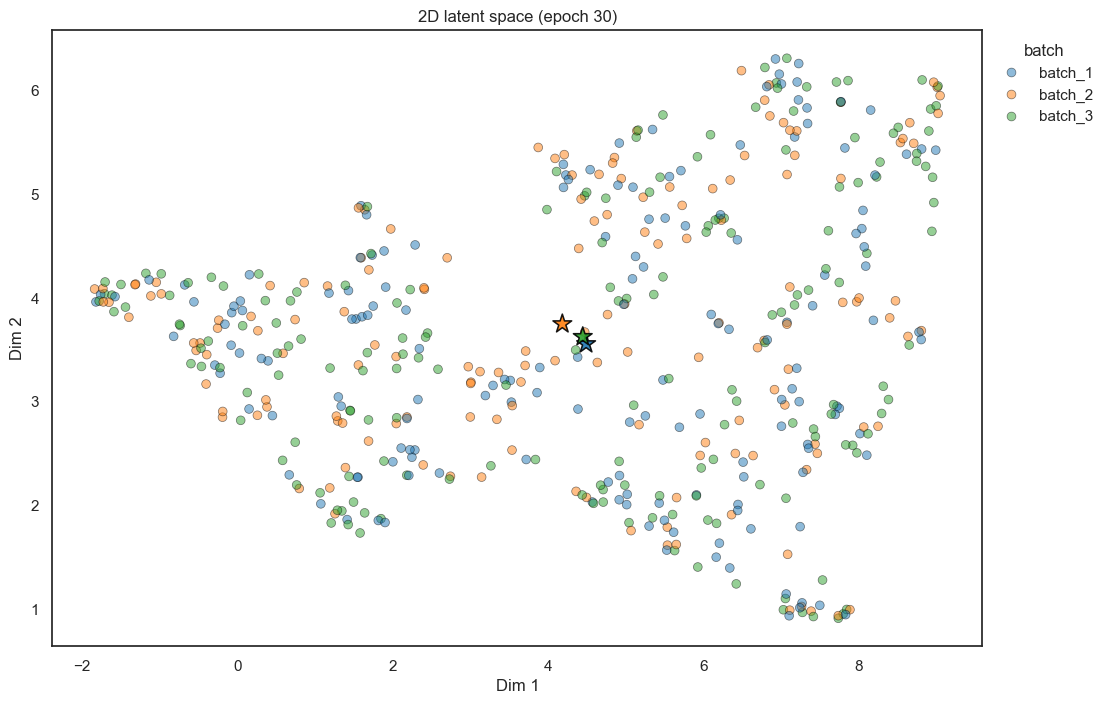

In [12]:
vanillix.show_result(params=["batch"])

## 5) Customize

To customize the behavior of our pipeline, you adjust the configuration.  
There are two ways to work with the config:

1. Create a customized instance of the config class.  
2. Provide a `yaml` file and use the config class to read it.  

We will focus on option 1 and show a few examples. For a deeper dive into configurations, please refer to [4].  

In this section, we demonstrate how to change the following:  
- Scaling method  
- Number of layers in the autoencoder  
- Number of epochs  
- Learning rate  
- Latent dimensions  
- Retrieve information about all config parameters  

[4] Tutorials/DeepDives/ConfigTutorial.ipynb <br>


Each pipeline (Vanillix, Varix, Stackix, …) has a corresponding configuration class.  
All configuration classes inherit from a common `DefaultConfig` class, which defines all customizable parameters.  
Child classes override only those parameters that have been set as sensible defaults for their specific pipeline.


In [13]:
from autoencodix.configs import VanillixConfig
# we simply import the specific config an init it with custom parameters
custom_config = VanillixConfig(
    scaling="MINMAX", n_layers=4, epochs=23, learning_rate=1e4, latent_dim=4, data_case="Multi Bulk"
)
# to see a list of all parameters and defaults use:
custom_config.print_schema()


VanillixConfig Configuration Parameters:
--------------------------------------------------

data_config:
  Type: <class 'autoencodix.configs.default_config.DataConfig'>
  Default: data_info={} require_common_cells=False annotation_columns=None
  Description: No description available

img_path_col:
  Type: <class 'str'>
  Default: img_paths
  Description: When working with images, we except a column in your annotation file that specifies the path of the image for a particular sample. Here you can define the name of this column

requires_paired:
  Type: typing.Optional[bool]
  Default: PydanticUndefined
  Description: Indicator if the samples for the xmodalix are paired, based on some sample id

data_case:
  Type: typing.Optional[autoencodix.configs.default_config.DataCase]
  Default: PydanticUndefined
  Description: Data case for the model, will be determined automatically

k_filter:
  Type: typing.Optional[int]
  Default: 20
  Description: Number of features to keep

scaling:
  Type:

In [14]:
# next we pass the config to our pipeline object
vanillix2 = acx.Vanillix(data=my_datapackage, config=custom_config)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>



## 6) Re-use, Save, Load

Lastly, we show how to re-use a trained pipeline, as well as how to save and load it.  
You can do the following:

- Use the trained pipeline to run the `predict` step with new data.  
- Obtain the latent space, apply transformations, and run the `decode` step of the trained pipeline.  
- Generate new data by computing  the mean and standard deviation of all encoded latent vectors in the chosen split and epoch, fitting a diagonal Gaussian to those statistics, and sampling new latent points by adding scaled Gaussian noise to that mean.
- Access the underlying PyTorch model and re-use it in any way you like.  
- Store the pipeline on disk or in the cloud, then reload it and continue using it.  


#### Run with New Data

In [15]:
# For demonstration purposes, we use the DataPackage from step 1 again.
# In real-world scenarios, you would use different data.
result_new_data = vanillix.predict(data=my_datapackage)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
n_samples in format recon: 500
train
n_samples from datatpackge: {'paired_count': 500}


#### Decode with Latent Space Shift

In [16]:
import numpy as np
import torch
latent = result.latentspaces.get(split="test", epoch=-1)
latent_shift = np.random.normal(0, 0.1, latent.shape)
new_latent = (latent + latent_shift).astype(np.float32)
vanillix.decode(torch.from_numpy(new_latent))

tensor([[-0.4357,  0.3061,  0.6443,  ...,  0.1662,  0.2861, -0.9564],
        [-0.1237,  0.1469,  0.3442,  ...,  0.0754,  0.2327, -0.4795],
        [ 0.1134, -0.1247, -0.3121,  ..., -0.0285,  0.0084,  0.1329],
        ...,
        [-0.3145, -0.1364,  0.2063,  ...,  0.1127,  0.1574, -0.1665],
        [ 0.0923, -0.1018, -0.3216,  ..., -0.0979, -0.0777,  0.1606],
        [ 0.0203, -0.1285,  0.0735,  ...,  0.0351,  0.1042,  0.0862]])

#### Generate New Data
While for a variational autoencoder this step is more intuitive, a vanilla autoencoder does not model a formal latent distribution. Instead, the generate method approximates one by computing the mean and standard deviation of all encoded latent vectors in the chosen split and epoch, fitting a diagonal Gaussian to these statistics, and sampling new latent points by adding scaled Gaussian noise to that mean.
You can generate data by passing n_samples, or you can bypass this empirical distribution entirely by providing your own latent_prior. This latent_prior needs to have the form `n_samples, latend_dim`. This case is basically the same as calling `decode` directly.

In [17]:
import torch

# Add this at the start of your cell
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
generated_reconstructions = vanillix.generate(n_samples=300)
print(f"Generated reconstructions shape: {generated_reconstructions.shape}")

Generated reconstructions shape: torch.Size([300, 20])


In [18]:
generated_from_prior = vanillix.generate(latent_prior=new_latent)
print(f"Generated from prior shape: {generated_from_prior.shape}")

Generated from prior shape: torch.Size([500, 20])


#### Obtain PyTorch Model

In [19]:
model = result.model
# then do something with the model
print(model)

VanillixArchitecture(
  (_encoder): Sequential(
    (0): Linear(in_features=20, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.1, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.1, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=16, out_features=16, bias=True)
  )
  (_decoder): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=16, out_feature

#### Save and Load
Best practice is to provide a file path without extension, we set the extensions internally and handle all saving and loading.

In [20]:
import os
import glob

outpath = os.path.join("tutorial_res", "van")
vanillix.save(file_path=outpath, save_all=True)

folder = os.path.dirname(outpath)
pkl_files = glob.glob(os.path.join(folder, "*.pkl"))
model_files = glob.glob(os.path.join(folder, "*.pth"))

print("PKL files:", pkl_files)
print("Model files:", model_files)

# The load functionality automatically rebuilds the pipeline object from the saved files
vanillix_loaded = acx.Vanillix.load(outpath)


Preprocessor saved successfully.
Pipeline object saved successfully.
PKL files: ['tutorial_res/disent.pkl.pkl', 'tutorial_res/stackix.pkl', 'tutorial_res/varix.pkl', 'tutorial_res/van.pkl.pkl', 'tutorial_res/disent.pkl_preprocessor.pkl', 'tutorial_res/stackix_preprocessor.pkl', 'tutorial_res/varix.pkl.pkl', 'tutorial_res/stackix.pkl.pkl', 'tutorial_res/varix_preprocessor.pkl']
Model files: ['tutorial_res/disent.pkl_model.pth', 'tutorial_res/stackix_model.pth', 'tutorial_res/varix_model.pth']
Attempting to load a pipeline from tutorial_res/van.pkl...
Pipeline object loaded successfully. Actual type: Vanillix
Preprocessor loaded successfully.


In [21]:
vanillix_loaded.predict(data=my_datapackage)
vanillix_loaded.visualize()

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
n_samples in format recon: 500
train
n_samples from datatpackge: {'paired_count': 500}


In [22]:
vanillix_loaded.visualize()

Creating plots ...


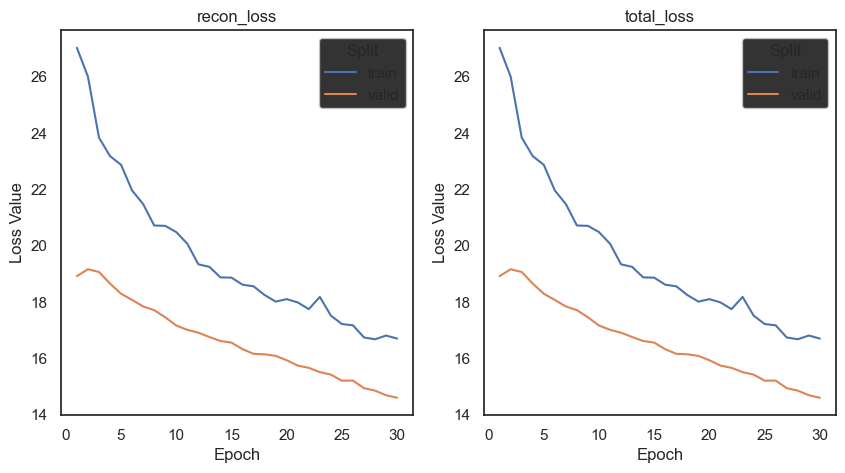

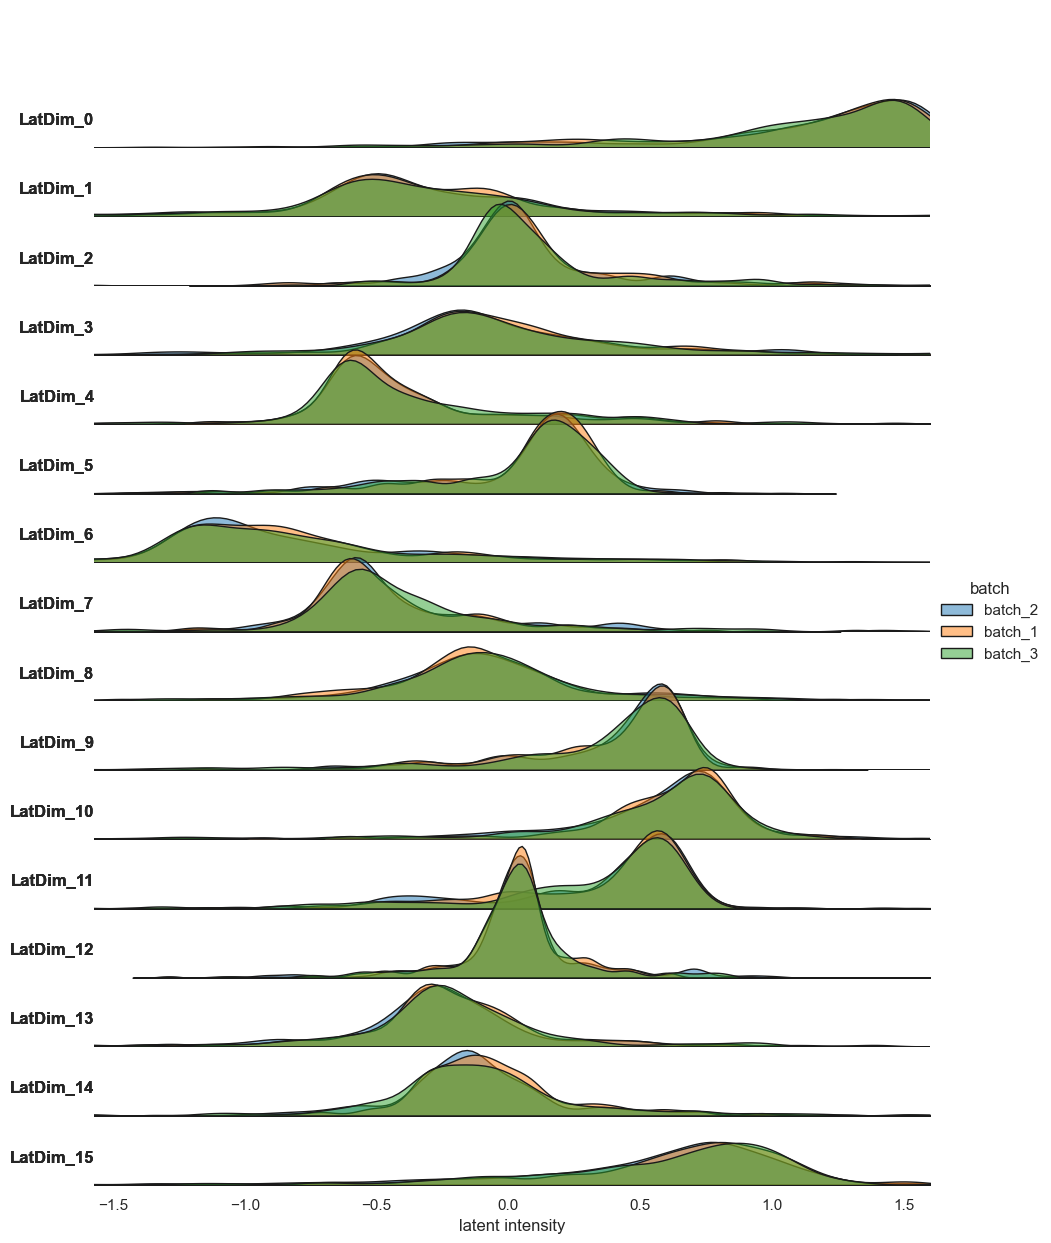

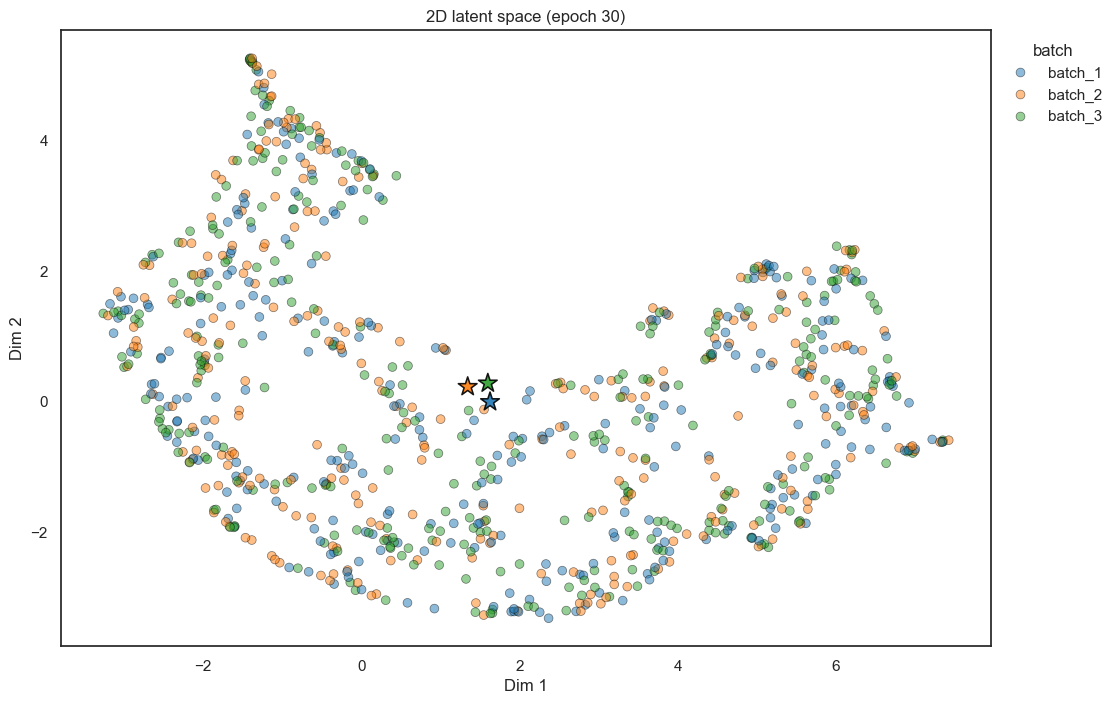

In [23]:
vanillix_loaded.show_result(params=["batch"])

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
n_samples in format recon: 500
train
n_samples from datatpackge: {'paired_count': 500}
Creating plots ...


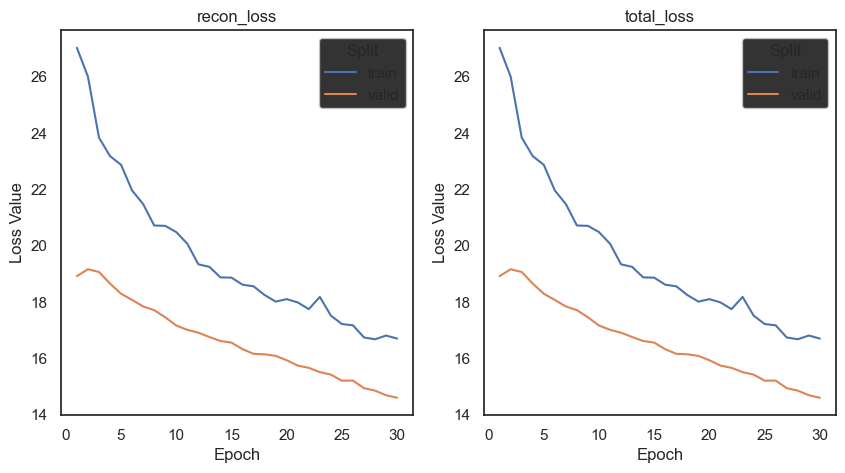

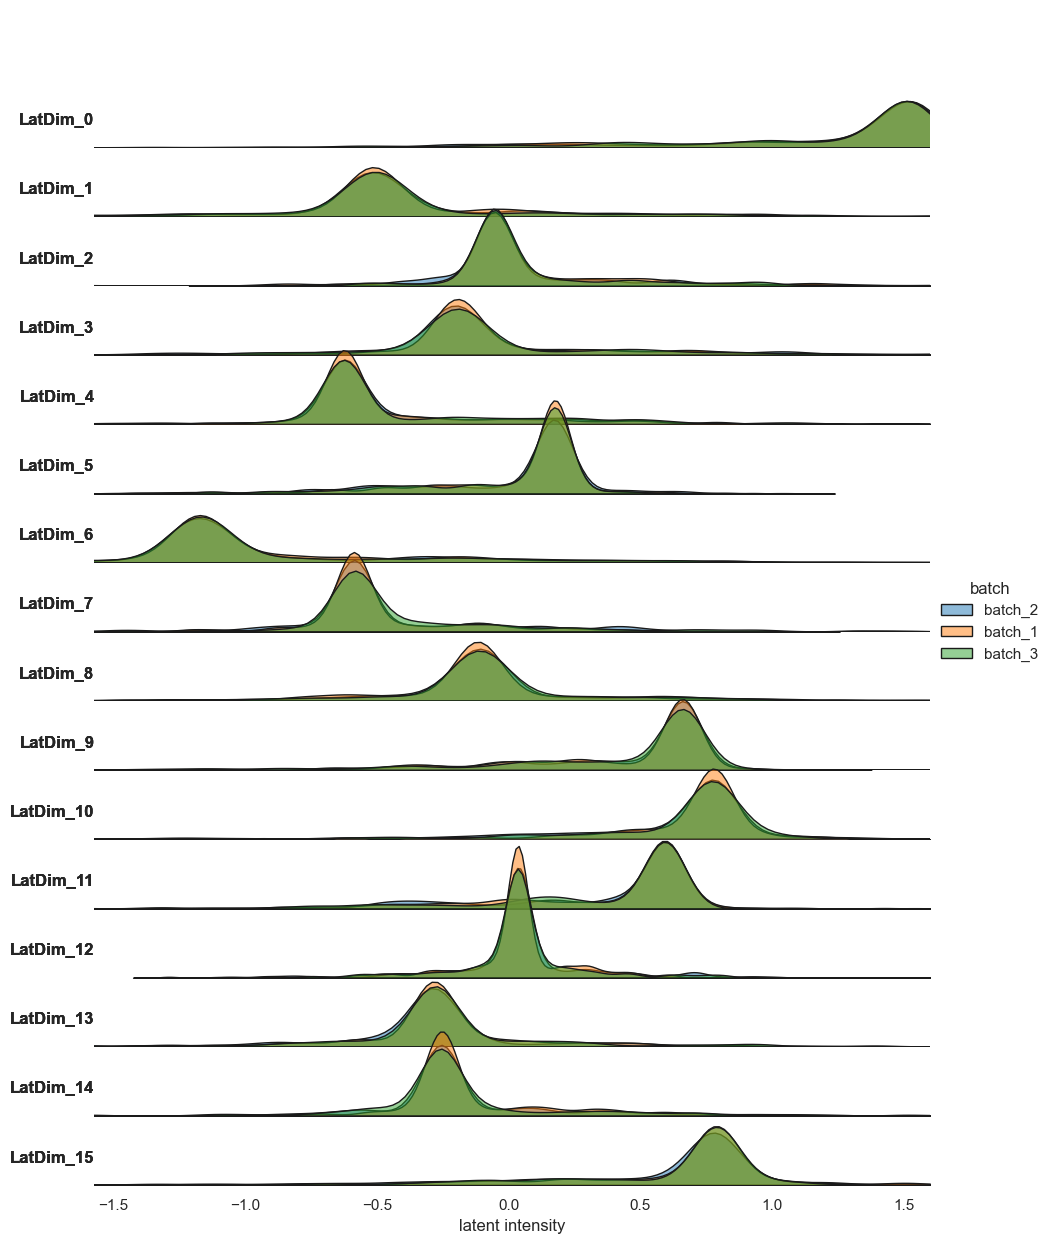

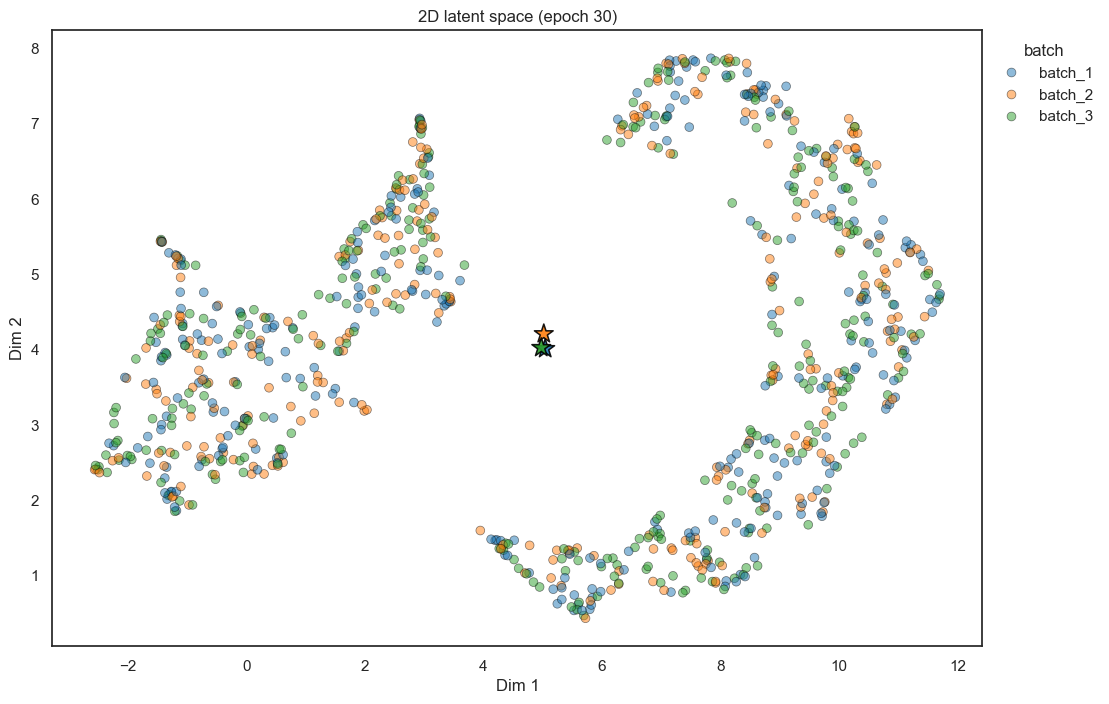

In [24]:
vanillix_loaded.predict(data=my_datapackage)
vanillix_loaded.show_result(params=["batch"])